Here is a summary of my attempts at handling missing data in our regression problem. At the end of this notebook, I included a draft post for the pymc3 help forum that explains a simplified version of our model, what we've tried, and why it's not working.

In [47]:
import pymc3 as pm
import numpy as np
import pandas as pd

# Approach #1: Impute missing y values only
I took the complete data set, separated it into x windows and "observed" y counts, and then manually replaced the y value at index 10 with NaN.

### Pros: 
- Super easy since PyMC3 automatically does this.

### Cons:
- Obviously, this doesn't make sense for our problem since the x's and y's come from the same values, so there is no way to only have missing y's.
- Treats x's and y's as separate independent and dependent variables, rather than 1 series of counts.
- Does not impute missing x values.
    - It is possible to treat the x's as observed (set a prior, sample missing values from the posterior), however this doesn't solve the issue of treating the x's and y's as separate variables, so I didn't bother trying that.

In [48]:
train_df = pd.read_csv("../Middlesex.csv")
counts = train_df['cases'].values.astype(float)

In [49]:
W = 4

N = len(counts) - W
x_train = np.vstack([counts[i:i+W] for i in range(N)])
y_train = counts[W:]

y_train[10] = np.nan # Inserting a missing value
y_train = pd.Series(y_train)

/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [alpha, beta_recent, beta, bias]
>Metropolis: [Y_obs_missing]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:23<00:00, 64.96it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


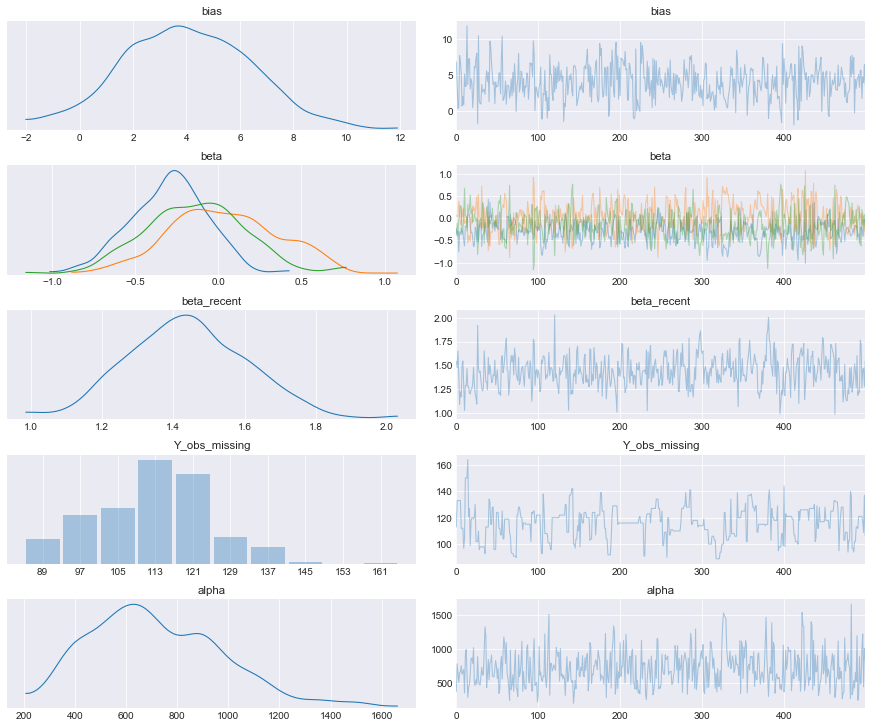

In [50]:
with pm.Model() as model:
    bias = pm.Normal('bias', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=(W-1,))
    beta_recent = pm.Normal('beta_recent', mu=1, sd=1)
    alpha = pm.TruncatedNormal('alpha', mu=200, sigma=500, lower=0)
    
    mu = bias
    for i in range(W-1):
        mu += beta[i] * x_train[:,i]
    mu += beta_recent * x_train[:,W-1]

    Y_obs = pm.NegativeBinomial('Y_obs', mu=mu, alpha=alpha, observed=y_train)

    trace = pm.sample(500, init='adapt_diag', chains=1, tune=1000)
    
pm.traceplot(trace);

In [51]:
post_mean = pm.summary(trace)['mean'].to_dict()

post_mean['alpha_lowerbound__'] = np.log(post_mean['alpha'])
post_mean['Y_obs_missing'] = [post_mean['Y_obs_missing[0]']]

beta = np.zeros(W-1)
for i in range(W-1):
    beta[i] = post_mean[f'beta[{i}]']
post_mean['beta'] = beta

for key in ['bias', 'beta', 'beta_recent', 'alpha', 'Y_obs_missing']:
    print(key, post_mean[key])

score = model['Y_obs'].logp(post_mean) / N
print(f'\nScore = {score}')

bias 3.995
beta [-0.3    0.036 -0.142]
beta_recent 1.438
alpha 722.185
Y_obs_missing [116.124]

Score = -4.982854107685266


# Approach #2: Define custom multivariate distribution
I defined a custom distribution that takes in an array of count data and calculates the log likelihood of the whole dataset.

### Pros:
- Now treating data as one set of values, rather than separating into x's and y's.

### Cons:
- Cannot handle missing values because there is no way to compute the likelihood if there are NaN's in the series.
- The data is treated as one giant sample from a joint distribution, so we now only have 1 example instead of N.

In [52]:
train_df = pd.read_csv("../Middlesex.csv")
counts = train_df['cases'].values.astype(float)

In [74]:
def likelihood(W, N, intercept, beta, beta_recent, alpha):
    
    def logp_(counts):

        counts = counts.eval()
        x = np.vstack([counts[i:i+W] for i in range(N)])
        y = counts[W:]

        mu = intercept
        for i in range(W-1):
            mu += beta[i] * x[:,i]
        mu += beta_recent * x[:,W-1]

        lik = pm.NegativeBinomial.dist(mu=mu, alpha=alpha)
  
        return lik.logp(y)
    
    return logp_

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta_recent, beta, intercept]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:23<00:00, 64.17it/s]


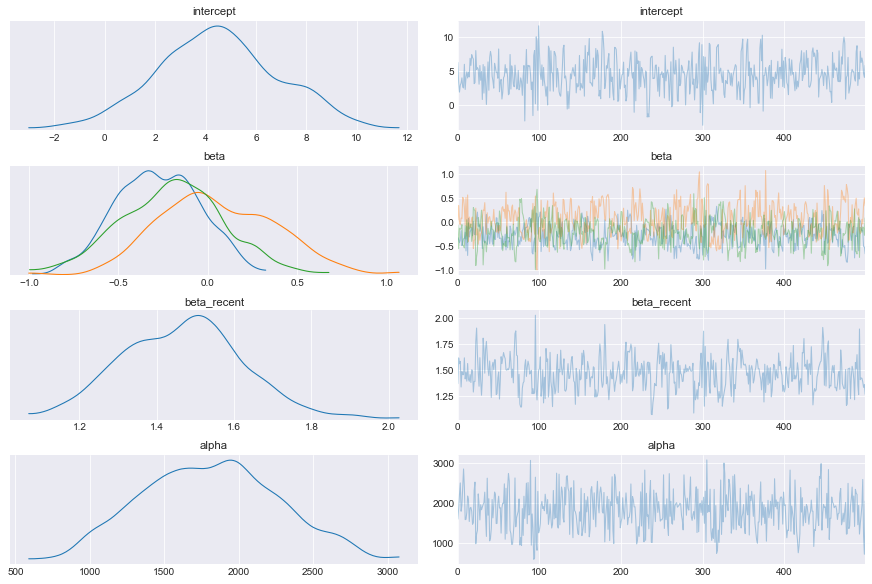

In [75]:
W = 4

with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=W-1)
    beta_recent = pm.Normal('beta_recent', mu=1, sd=1)
    alpha = pm.TruncatedNormal('alpha', mu=2000, sigma=500, lower=0)

    Y_obs = pm.DensityDist('Y_obs',
                           likelihood(W, len(counts)-W, intercept, beta, beta_recent, alpha),
                           observed=counts)
    
    trace = pm.sample(500, init='adapt_diag', chains=1, tune=1000,
                      compute_convergence_checks=False)

pm.traceplot(trace);

In [76]:
post_mean = pm.summary(trace)['mean'].to_dict()

post_mean['alpha_lowerbound__'] = np.log(post_mean['alpha'])

beta = np.zeros(W-1)
for i in range(W-1):
    beta[i] = post_mean[f'beta[{i}]']
post_mean['beta'] = beta

for key in ['intercept', 'beta', 'beta_recent', 'alpha']:
    print(key, post_mean[key])

N = len(counts) - W
score = model['Y_obs'].logp(post_mean) / N
print(f'\nScore = {score}')

intercept 4.458
beta [-0.282  0.05  -0.203]
beta_recent 1.466
alpha 1807.81

Score = -4.973371198645784


# Question for PyMC3 discourse page

## Handling missing data in linear regression on timeseries data

We would like to perform linear regression on timeseries data, where each data point is conditioned on the previous one, i.e. we want to learn coefficients $b_0$ and $b_1$ such that

$$y_t \sim N(\mu = b_0 + b_1 * y_{t-1}, \sigma = 1)$$

for all $t$. We have been able to create a model that does this when we have complete data, but we are stuck on how to get our model to handle missing data. Using the following code to define our model, PyMC3 is able to easily impute any missing y values. However, for this particular problem, the x values are the same as the y values (just offset by 1 index), so missing y's are the same as missing x's.

In [81]:
data = np.arange(10)
x = data[:-1]
y = data[1:]

In [82]:
with pm.Model() as model:
    beta = pm.Normal('bias', mu=0, sd=10, shape=2)
    mu = beta[0] + beta[1] * x
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=1, observed=y)

We then tried defining a custom multivariate distribution over our entire dataset so that it would be treated as one series of values, rather than having to separate it into x's and y's prior to entering the model. This solution still wasn't able to handle missing data since there is no way to compute the likelihood of the distribution when there are NaN's in the data.

In [84]:
def likelihood(beta):
    
    def logp_(data):
        data = data.eval()
        x = counts[:-1]
        y = counts[1:]
        mu = beta[0] + beta[1] * x
        lik = pm.Normal.dist(mu=mu, sigma=1)
        return lik.logp(y)
    
    return logp_

with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    Y_obs = pm.DensityDist('Y_obs', likelihood(beta), observed=data)